This notebook contains the "fast" modelling approach, using the measurements from the previous days for prediction.

Due to the limited number of training examples (due to the nature of the data and the constraints of modelling), random forest is used. We also use the "future" discharge and the water level measurements (where applicable) in order to simulate using their respective predictions in a deployed system.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

# Discharge data

- Discharge data shows 3 sites, with data every hour from Jan 1st 2011 to 2018 Sep 30
- Presumably it shows 3 sites where the canal discharges
- It could be the stream flow or the stream height

In [ ]:
dischargeDF = pd.read_csv('../data/raw/discharge_data.csv', sep=';')
dischargeDF['date'] = pd.to_datetime(dischargeDF['date'], format='%Y-%m-%d %H:%M:%S')
dischargeDF.set_index('date', inplace=True)

print(dischargeDF.shape)
print(dischargeDF.dtypes)

In [3]:
# not sure what this data is
dischargeDF

LOBH  PANNDSKP   TIELWL
date                                           
2011-01-01 00:00:00  3013.06   2038.82  2226.19
2011-01-01 01:00:00  3020.52   2021.56  2220.13
2011-01-01 02:00:00  3006.15   2016.98  2208.09
2011-01-01 03:00:00  2991.81   2020.43  2202.11
2011-01-01 04:00:00  2970.10   2015.85  2190.25
...                      ...       ...      ...
2018-09-30 19:00:00   929.10    719.09   734.08
2018-09-30 20:00:00   929.10    698.59   731.02
2018-09-30 21:00:00   929.10    674.40   734.08
2018-09-30 22:00:00   911.71    695.40   734.08
2018-09-30 23:00:00   916.54    683.36   734.08

[67920 rows x 3 columns]

<AxesSubplot:xlabel='date'>

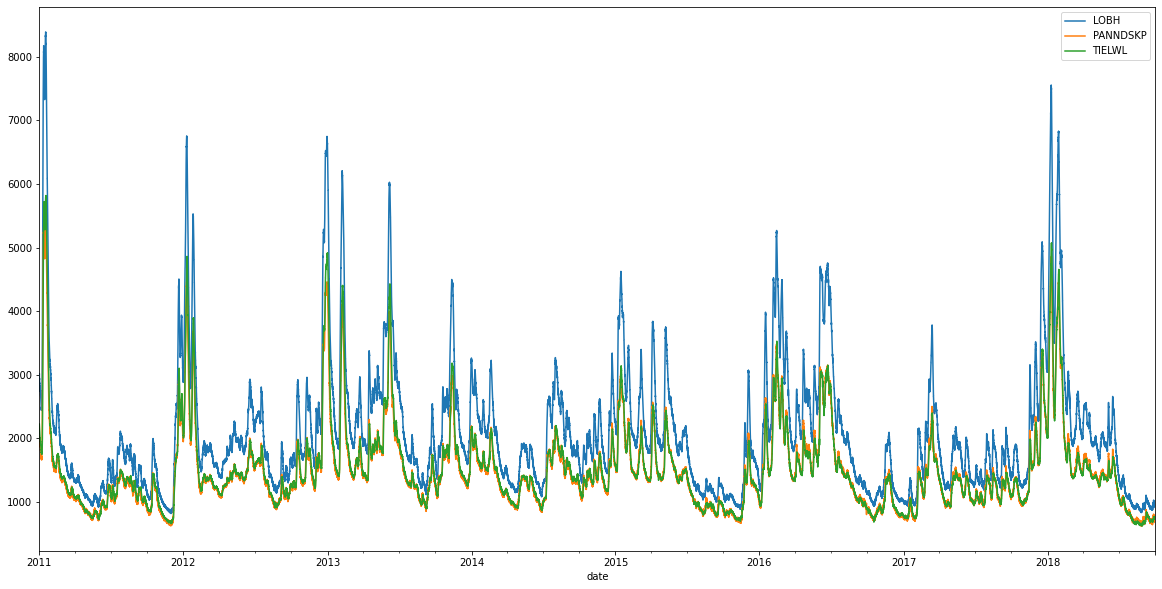

In [94]:
fig,ax = plt.subplots(figsize=(20,10))

dischargeDF.plot(ax=ax)
# ax.set_xlim('2011-12','2012-02')

# Depth data

In [5]:
depthDF = pd.read_pickle('../data/processed/big_depths_shipping_canal.p.gz')

print(depthDF.shape)
print(depthDF.dtypes)

(421698, 7)
date                   datetime64[ns]
region_id                     float64
depth_cm                      float64
source                         object
BM_index                      float64
assignment                     object
distance_to_closest           float64
dtype: object


First, we explore how much data is actually available for this approach.

In [98]:
depthDF
# depth data from 2011 Jan to 2018 July, with region ids, depth in cm. source is mainly bi=weekly, with some daily

date  region_id  depth_cm source  BM_index assignment  \
0      2011-01-03     1799.0     420.0  daily       NaN     within   
1      2011-01-04     1799.0     490.0  daily       NaN     within   
2      2011-01-05     1796.0     480.0  daily       NaN     within   
3      2011-01-06     1799.0     460.0  daily       NaN     within   
4      2011-01-07     1802.0     470.0  daily       NaN     within   
...           ...        ...       ...    ...       ...        ...   
421693 2018-07-30     1535.0     250.0  daily       NaN     within   
421694 2018-07-30     1562.0     260.0  daily       NaN     within   
421695 2018-07-30     1805.0     270.0  daily       NaN     within   
421696 2018-07-31      117.0     210.0  daily       NaN     within   
421697 2018-07-31      260.0     240.0  daily       NaN    closest   

        distance_to_closest  
0                  0.000000  
1                  0.000000  
2                  0.000000  
3                  0.000000  
4                  0.000000  
...                     ...  
421693             0.000000  
421694             0.000000  
421695             0.000000  
421696             0.000000  
421697             7.847093  

[421698 rows x 7 columns]

In [99]:
depthDF['source'].value_counts()

biweekly    417650
daily         4048
Name: source, dtype: int64

In [7]:
# pivote to show date against region id
# data over 2767 days
pivDF = pd.pivot_table(depthDF, index='date', columns='region_id', values='depth_cm')
full_index = pd.date_range(start=pivDF.index.min(), end=pivDF.index.max(), freq='1D') # creates fully filled index
pivDF = pivDF.reindex(full_index)

print(pivDF.shape)
pivDF

(2767, 2510)


region_id   0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0     \
2011-01-03     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2011-01-04     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2011-01-05     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2011-01-06     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2011-01-07     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2018-07-27     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-07-28     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-07-29     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-07-30     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-07-31     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

region_id   8.0     9.0     ...  2503.0  2504.0  2505.0  2506.0  2507.0  \
2011-01-03     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2011-01-04     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2011-01-05     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2011-01-06     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2011-01-07     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2018-07-27     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2018-07-28     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2018-07-29     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2018-07-30     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2018-07-31     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   

region_id   2508.0  2509.0  2510.0  2513.0  2528.0  
2011-01-03     NaN     NaN     NaN     NaN     NaN  
2011-01-04     NaN     NaN     NaN     NaN     NaN  
2011-01-05     NaN     NaN     NaN     NaN     NaN  
2011-01-06     NaN     NaN     NaN     NaN     NaN  
2011-01-07     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...  
2018-07-27     NaN     NaN     NaN     NaN     NaN  
2018-07-28     NaN     NaN     NaN     NaN     NaN  
2018-07-29     NaN     NaN     NaN     NaN     NaN  
2018-07-30     NaN     NaN     NaN     NaN     NaN  
2018-07-31     NaN     NaN     NaN     NaN     NaN  

[2767 rows x 2510 columns]

In [8]:
for i in tqdm(range(1,28)):
    print('Number of measurements {} days apart: {} across {} regions.'.format(
        i,
        pivDF.size - pivDF.diff(i).isnull().sum().sum(),# seeing how many entries have values adjacent to each other in days
        (pivDF.diff(i).count() > 0).sum())
         )

  0%|          | 0/27 [00:00<?, ?it/s]

Number of measurements 1 days apart: 2830 across 290 regions.
Number of measurements 2 days apart: 2417 across 361 regions.
Number of measurements 3 days apart: 3801 across 1375 regions.
Number of measurements 4 days apart: 7838 across 2157 regions.
Number of measurements 5 days apart: 12136 across 2509 regions.
Number of measurements 6 days apart: 18460 across 2509 regions.
Number of measurements 7 days apart: 24742 across 2359 regions.
Number of measurements 8 days apart: 18705 across 2509 regions.
Number of measurements 9 days apart: 12398 across 2509 regions.
Number of measurements 10 days apart: 15681 across 2509 regions.
Number of measurements 11 days apart: 13860 across 2509 regions.
Number of measurements 12 days apart: 19496 across 2509 regions.
Number of measurements 13 days apart: 30840 across 2509 regions.
Number of measurements 14 days apart: 39429 across 2509 regions.
Number of measurements 15 days apart: 36444 across 2509 regions.
Number of measurements 16 days apart: 22

We also assume that the measurements done close in time to each other are well correlated. Below, we explore this a bit more formally, showing that indeed the smaller the time between the depth measurements, the better they are correlated.

In [9]:
pd.melt(pivDF.diff(1).reset_index(), id_vars='index').dropna()

index region_id      value
1466    2015-01-08       0.0  41.800005
4233    2015-01-08       1.0  42.000014
7000    2015-01-08       2.0  51.300008
9767    2015-01-08       3.0  61.299998
12534   2015-01-08       4.0  44.699986
...            ...       ...        ...
6341148 2016-05-07    2294.0   0.000000
6341797 2018-02-15    2294.0   0.000000
6591998 2013-10-03    2385.0 -10.000000
6591999 2013-10-04    2385.0 -10.000000
6592000 2013-10-05    2385.0   0.000000

[2830 rows x 3 columns]

In [10]:
corrs = []
stds = []

for i in tqdm(range(1,28)):
    sys.stdout.write(f'\rDoing offset of {i} days.')
    
    tmpDF = pd.melt(pivDF.diff(i).reset_index(), id_vars='index').dropna()
    tmpDF.rename(columns={'index':'date', 'value': 'difference'}, inplace=True)
    tmpDF['date'] = tmpDF['date'] - pd.Timedelta(days=i)
    tmpDF['region_id'] = tmpDF['region_id'].astype(float)
    
    tmpDF = pd.merge(tmpDF, depthDF[['date', 'region_id', 'depth_cm']], on=['date', 'region_id'])
    
    tmpDF['next'] = tmpDF['depth_cm'] + tmpDF['difference']
    
    tmp_corrs = []
    for i in range(1000):
        tmp_corrs.append(tmpDF[['depth_cm', 'next']].sample(100, replace=True).corr().iloc[0,1])
    
    tmp_corrs = np.array(tmp_corrs)
    corrs.append(np.mean(tmp_corrs))
    stds.append(np.std(tmp_corrs))

corrs = np.array(corrs)
stds = np.array(stds)

  0%|          | 0/27 [00:00<?, ?it/s]

Doing offset of 27 days.

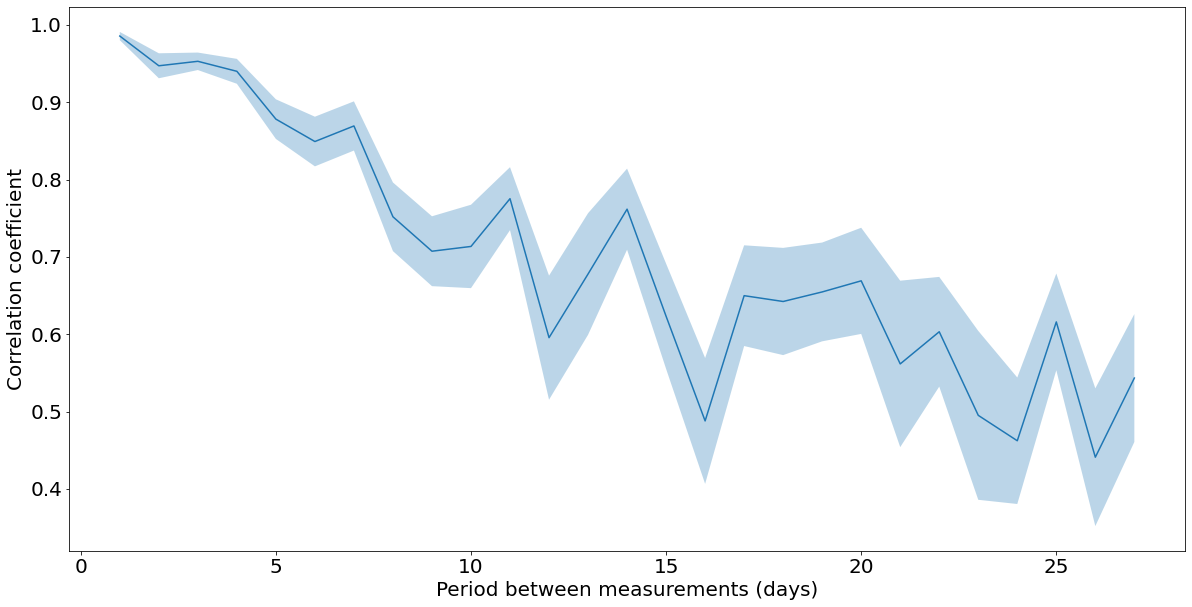

In [11]:
fig,ax = plt.subplots(figsize=(20,10))

ax.fill_between(range(1,1+len(corrs)), corrs-stds, corrs+stds, alpha=0.3)

ax.plot(range(1,1+len(corrs)), corrs)
ax.set_xlabel('Period between measurements (days)', fontsize=20)
ax.set_ylabel('Correlation coefficient', fontsize=20)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

In [12]:
corrDF = pd.DataFrame(columns=['offset', 'region_id', 'corr_coeff'])

for i in tqdm(range(1,28)):
    sys.stdout.write('\rDoing offset of {} days.'.format(i))
    
    tmpDF = pd.melt(pivDF.diff(i).reset_index(), id_vars='index').dropna()
    tmpDF.rename(columns={'index':'date', 'value': 'difference'}, inplace=True)
    tmpDF['date'] = tmpDF['date'] - pd.Timedelta(days=i)
    tmpDF['region_id'] = tmpDF['region_id'].astype(float)
    
    tmpDF = pd.merge(tmpDF, depthDF[['date', 'region_id', 'depth_cm']], on=['date', 'region_id'])
    
    tmpDF['next'] = tmpDF['depth_cm'] + tmpDF['difference']
    
    tmp_corrs = pd.DataFrame(columns=corrDF.columns, index=range(tmpDF['region_id'].nunique()))
    
    for c, (reg,grp) in enumerate(tmpDF.groupby('region_id')):
        tmp_corrs.iloc[c] = {'offset': i,
                             'region_id': reg, 
                             'corr_coeff': grp[['depth_cm', 'next']].corr().iloc[0,1]}
    
    corrDF = pd.concat([corrDF, tmp_corrs])

  0%|          | 0/27 [00:00<?, ?it/s]

Doing offset of 27 days.

In [13]:
corrDF.dropna().head()

offset region_id corr_coeff
76    1.0      76.0   0.866153
81    1.0      81.0        1.0
93    1.0      93.0   0.991435
97    1.0      97.0     0.9961
99    1.0      99.0    0.99846

<AxesSubplot:title={'center':'corr_coeff'}, xlabel='offset'>

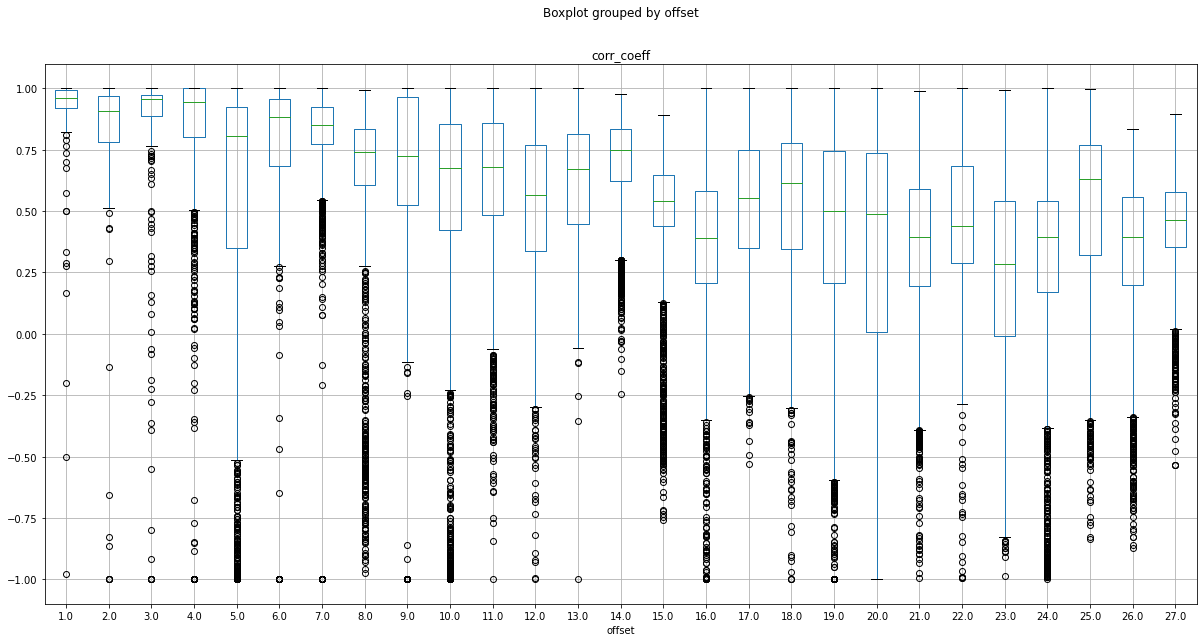

In [14]:
fig,ax = plt.subplots(figsize=(20,10))

corrDF[['offset','corr_coeff']].dropna().boxplot(column='corr_coeff', by='offset', ax=ax)

# Modelling using the previous day and discharge data

Number of consecutive measurements with regions with at least 10 of them: 2399


<AxesSubplot:xlabel='region_id'>

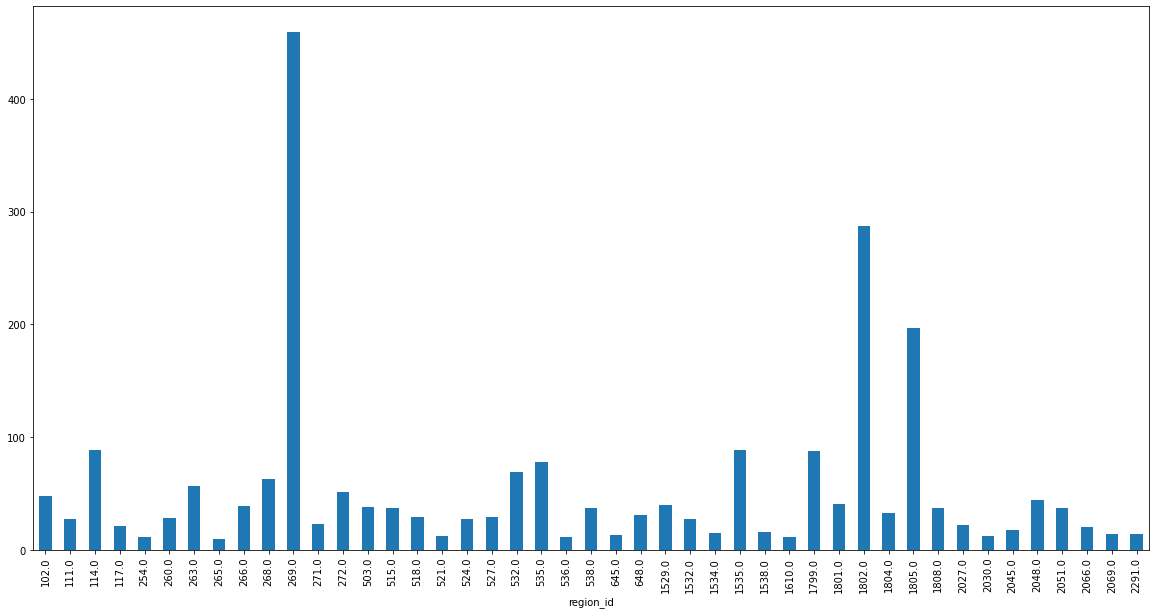

In [16]:
fig,ax = plt.subplots(figsize=(20,10))

cnt = pivDF.diff().count()
print('Number of consecutive measurements with regions with at least 10 of them: {}'.format(cnt[cnt>9].sum()))
cnt[cnt>9].plot.bar(ax=ax)

Try predicting the measurement on the following day. As features, we will use:

- The current measurement
- The discharge measurements from yesterday until tomorrow
- Region ID

Later we might add more:

- Expand the range of discharge measurements
- Other region metadata (km along the river, topology of the river)
- Values of past nearby measurements

In [107]:
cnt = pivDF.diff().count() # how many measurements on the consecutive days there are 

dataDF = pd.DataFrame(columns=['today', 'diff_tomorrow', 'region_id'])

for i, region in enumerate(cnt[cnt > 0].index):
    sys.stdout.write('\rDoing region {} ({}/{})'.format(region,i+1, (cnt > 0).sum()))
    
    tmpDF = pivDF.diff()[region].dropna().copy()
    tmpDF.index = tmpDF.index.map(lambda x: x - pd.Timedelta(days=1))
    tmpDF = pd.DataFrame(tmpDF)
    tmpDF.columns = ['diff_tomorrow']
    tmpDF['today'] = pivDF.loc[tmpDF.index,region]
    tmpDF['region_id'] = region
    
    dataDF = pd.concat([dataDF, tmpDF], axis=0)

Doing region 2385.0 (290/290)

In [18]:
dataDF.sample(5)

today  diff_tomorrow  region_id
2017-04-25  320.0            0.0      269.0
2017-08-31  340.0          -10.0     1804.0
2013-07-11  410.0          -30.0     1802.0
2017-06-24  280.0           10.0     1535.0
2017-05-18  440.0          -20.0      527.0

In [110]:
dataDF.sort_index()

today  diff_tomorrow  region_id
2011-01-03  420.0           70.0     1799.0
2011-02-03  480.0          -30.0     1799.0
2011-02-05  440.0          -10.0      254.0
2011-02-06  430.0          -30.0      254.0
2011-02-08  410.0            0.0      533.0
...           ...            ...        ...
2018-07-28  230.0          -10.0      112.0
2018-07-29  250.0            0.0     1535.0
2018-07-29  270.0            0.0     1805.0
2018-07-30  215.0           -5.0      117.0
2018-07-30  240.0            0.0      260.0

[2830 rows x 3 columns]

In [119]:
disDF = pd.DataFrame(columns=['discharge_{}h'.format(i) for i in range(-24,49)])

for i,(ind,row) in enumerate(dataDF.iterrows()):
    sys.stdout.write('\rDoing row {}/{}'.format(i+1,len(dataDF)))
    
    disDF.loc[len(disDF)] = dischargeDF.loc[ind - pd.Timedelta(hours=16):ind + pd.Timedelta(days=2, hours=8), 'PANNDSKP'].values

Doing row 2830/2830

In [120]:
dataDF.reset_index(inplace=True)
dataDF.rename(columns={'index':'date'}, inplace=True)

In [121]:
dataDF = pd.merge(disDF,dataDF, left_index=True, right_index=True)
dataDF.sort_values(by='date', inplace=True)

In [124]:
print(dataDF.shape)
dataDF

(2830, 77)


discharge_-24h  discharge_-23h  discharge_-22h  discharge_-21h  \
1923         1925.48         1925.48         1905.60         1920.95   
1924         1711.80         1707.46         1703.13         1698.80   
394          1593.25         1593.25         1600.28         1589.01   
395          1574.92         1574.92         1586.11         1581.88   
1423         1512.13         1507.98         1519.03         1507.98   
...              ...             ...             ...             ...   
214           844.28          852.40          863.81          844.28   
1869          824.05          835.59          840.34          820.69   
2568          824.05          835.59          840.34          820.69   
329           803.99          780.51          808.93          777.16   
441           803.99          780.51          808.93          777.16   

      discharge_-20h  discharge_-19h  discharge_-18h  discharge_-17h  \
1923         1940.75         1928.61         1924.08         1924.08   
1924         1717.69         1713.34         1709.00         1693.11   
394          1596.06         1618.52         1607.30         1603.05   
395          1581.91         1581.91         1574.94         1570.72   
1423         1508.00         1503.85         1508.00         1503.85   
...              ...             ...             ...             ...   
214           852.42          875.15          844.29          840.91   
1869          832.25          835.60          832.25          840.36   
2568          832.25          835.60          832.25          840.36   
329           788.98          805.63          785.65          802.32   
441           788.98          805.63          785.65          802.32   

      discharge_-16h  discharge_-15h  ...  discharge_43h  discharge_44h  \
1923         1916.46         1924.08  ...        1742.99        1750.39   
1924         1697.43         1693.11  ...        1579.14        1579.14   
394          1603.05         1589.03  ...        1527.36        1523.20   
395          1570.72         1559.52  ...        1506.58        1495.55   
1423         1503.85         1521.75  ...        1483.03        1490.01   
...              ...             ...  ...            ...            ...   
214           852.42          824.40  ...         780.80         789.14   
1869          832.25          824.06  ...         764.39         769.52   
2568          832.25          824.06  ...         764.39         769.52   
329           794.03          782.32  ...         757.86         746.08   
441           794.03          782.32  ...         757.86         746.08   

      discharge_45h  discharge_46h  discharge_47h  discharge_48h       date  \
1923        1734.27        1741.66        1744.64        1744.64 2011-01-03   
1924        1579.14        1579.14        1574.92        1574.92 2011-02-03   
394         1512.13        1512.13        1505.21        1512.13 2011-02-05   
395         1481.69        1506.58        1506.58        1524.42 2011-02-06   
1423        1519.10        1514.93        1510.78        1521.80 2011-02-08   
...             ...            ...            ...            ...        ...   
214          777.50         792.42         800.66         789.14 2018-07-28   
1869         761.11         752.62         761.11         769.52 2018-07-29   
2568         761.11         752.62         761.11         769.52 2018-07-29   
329          742.81         734.18         754.60         774.61 2018-07-30   
441          742.81         734.18         754.60         774.61 2018-07-30   

      today  diff_tomorrow  region_id  
1923  420.0           70.0     1799.0  
1924  480.0          -30.0     1799.0  
394   440.0          -10.0      254.0  
395   430.0          -30.0      254.0  
1423  410.0            0.0      533.0  
...     ...            ...        ...  
214   230.0          -10.0      112.0  
1869  250.0            0.0     1535.0  
2568  270.0            0.0     1805.0  
329   215.0           -5.0

In [125]:
dataDF['date'].map(lambda x : x.year).unique()

for y in dataDF['date'].map(lambda x : x.year).unique():
    print('Fraction before {}: {}%'.format(y, 100*len(dataDF[dataDF['date'] < '{}'.format(y)])/len(dataDF)))

Fraction before 2011: 0.0%
Fraction before 2012: 6.890459363957597%
Fraction before 2013: 12.720848056537102%
Fraction before 2014: 18.51590106007067%
Fraction before 2015: 25.47703180212014%
Fraction before 2016: 38.72791519434629%
Fraction before 2017: 45.01766784452297%
Fraction before 2018: 80.70671378091873%


In [26]:
train_X = dataDF[dataDF['date'] < '2018'].drop(['date','diff_tomorrow'], axis=1)
train_y = dataDF.loc[dataDF['date'] < '2018', 'diff_tomorrow']

test_X = dataDF[dataDF['date'] >= '2018'].drop(['date','diff_tomorrow'], axis=1)
text_y = dataDF.loc[dataDF['date'] >= '2018', 'diff_tomorrow']

In [31]:
et = ExtraTreesRegressor(n_estimators=100)

et.fit(train_X, train_y)

ExtraTreesRegressor()

Text(0, 0.5, 'Feature importance')

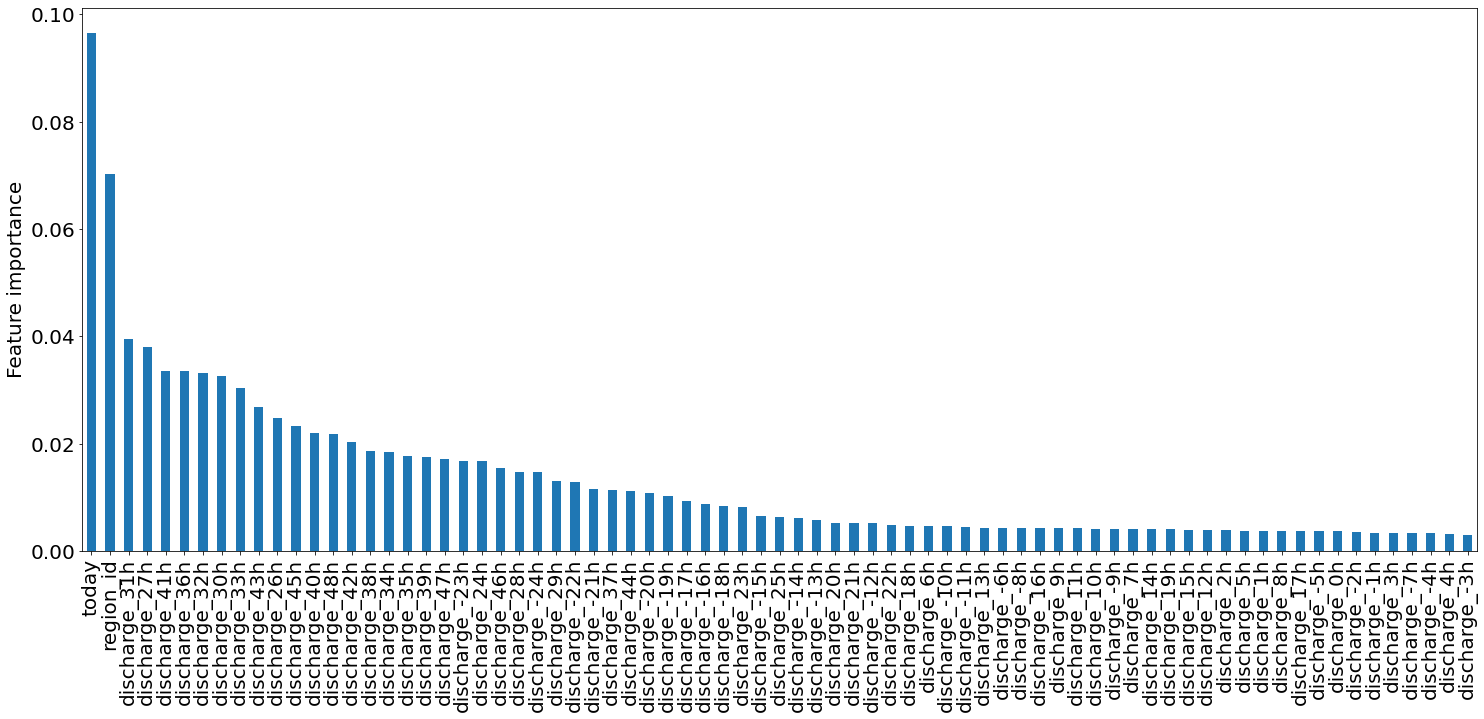

In [32]:
feat_imp = pd.Series(et.feature_importances_)
feat_imp.index = train_X.columns
feat_imp.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(25,10))

feat_imp.plot.bar(ax=ax, color='#1f77b4')

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

ax.set_ylabel('Feature importance', fontsize=20)

In [33]:
predDF = dataDF.loc[dataDF['date'] >= '2018', ['date', 'region_id', 'today', 'diff_tomorrow']]
predDF['pred_diff_tomorrow'] = et.predict(test_X)

predDF.head()

date  region_id  today  diff_tomorrow  pred_diff_tomorrow
592  2018-02-12      268.0  470.0          -10.0           -5.899500
1667 2018-02-13     1511.0  480.0            0.0           -9.882000
593  2018-02-13      268.0  460.0          -20.0           -9.210999
1916 2018-02-14     1766.0  460.0            0.0           14.360501
1668 2018-02-14     1511.0  480.0          -40.0            1.171001

In [34]:
predicted_values = predDF.copy()
predicted_values.set_index('date', inplace=True)
predicted_values['measured'] = predicted_values['today'] + predicted_values['diff_tomorrow']
predicted_values['predicted'] = predicted_values['today'] + predicted_values['pred_diff_tomorrow']
predicted_values.drop(['diff_tomorrow', 'pred_diff_tomorrow'], axis=1, inplace=True)
predicted_values.index = predicted_values.index.map(lambda x: x + pd.Timedelta(days=1))
predicted_values.rename(columns={'today':'previous'}, inplace=True)

predicted_values.sample(5)

region_id  previous  measured  predicted
date                                                
2018-05-31     1802.0     370.0     370.0   374.7910
2018-03-02     1808.0     450.0     440.0   439.8220
2018-04-13     2027.0     420.0     420.0   421.1635
2018-04-12       97.0     430.0     410.0   431.2050
2018-05-29     1532.0     380.0     399.6   378.2280

In [35]:
predicted_values['region_id'].value_counts().iloc[:5]

1802.0    35
102.0     30
2051.0    26
2048.0    25
1805.0    24
Name: region_id, dtype: int64

In [37]:
def get_accuracy(true, pred):
    mask = true != 0
    
    return 1 - np.mean(np.abs((true[mask] - pred[mask])/true[mask]))
                       
def get_u2(y_true, y_pred, prev):
    mask = y_true != 0
    
    internal_true = y_true[mask].values
    internal_pred = y_pred[mask].values
    internal_prev = prev[mask].values
    
    num = np.sqrt(np.mean((internal_true - internal_pred)**2/internal_true**2))
    den = np.sqrt(np.mean((internal_true - internal_prev)**2/internal_true**2))
    
    if den == 0:
        return np.nan
    
    return num/den

def get_rmse(true,pred):
    return np.sqrt(mse(true,pred))

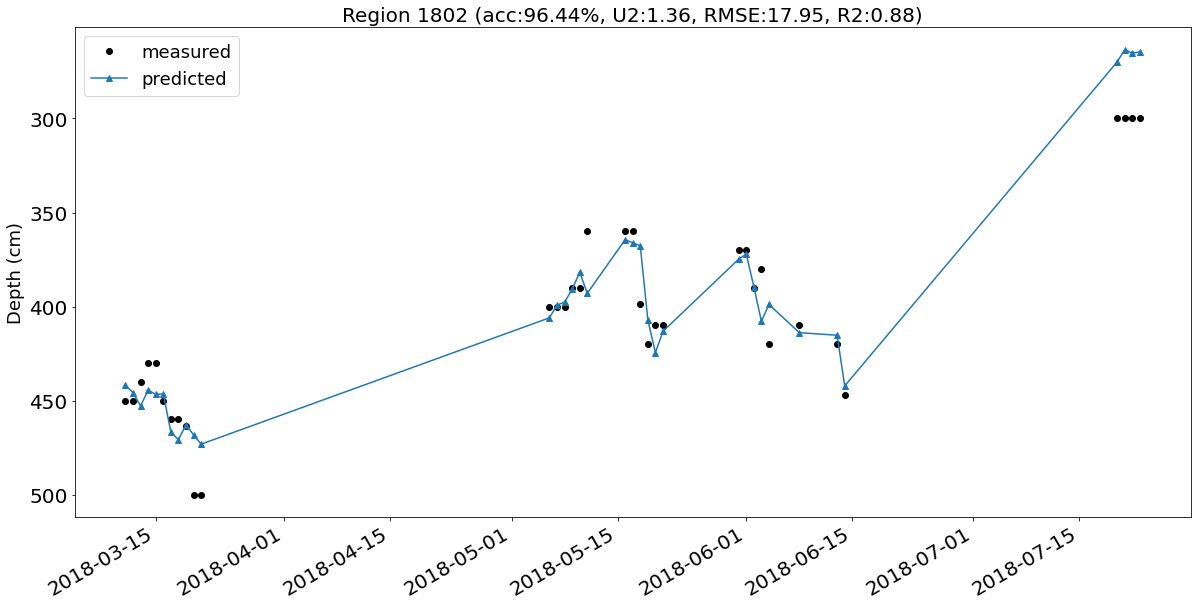

In [38]:
region = 1802

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


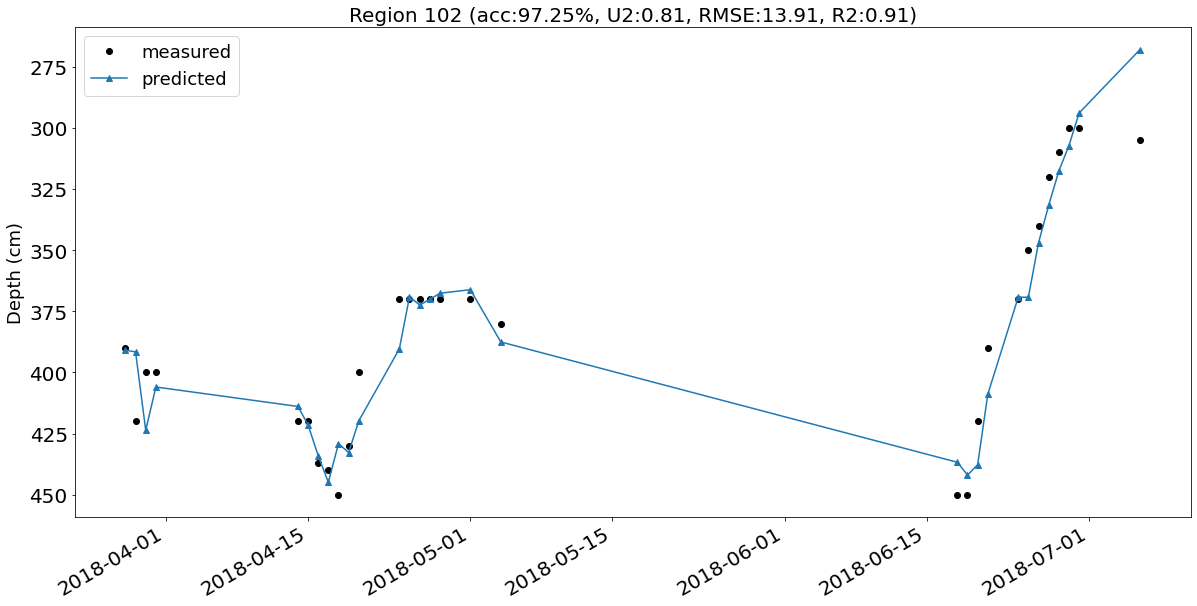

In [39]:
region = 102

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


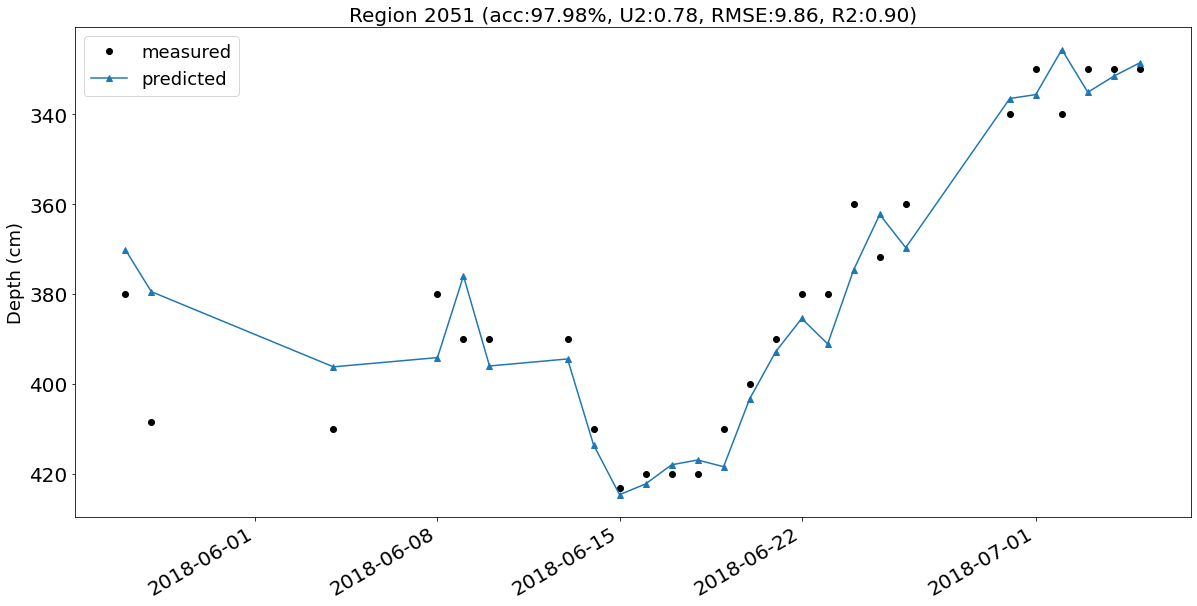

In [40]:
region = 2051

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

Text(0.5, 1.0, 'Region 2048 (acc:97.45%, U2:1.94, RMSE:12.72, R2:0.71)')

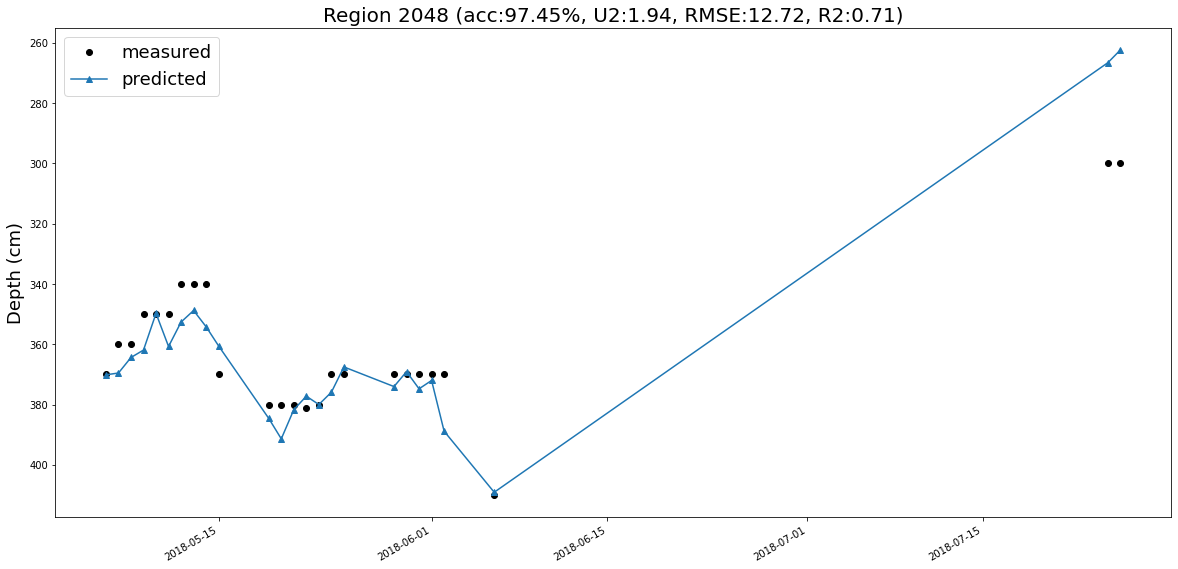

In [41]:
region = 2048

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

Text(0.5, 1.0, 'Region 1805 (acc:97.55%, U2:0.85, RMSE:12.65, R2:0.97)')

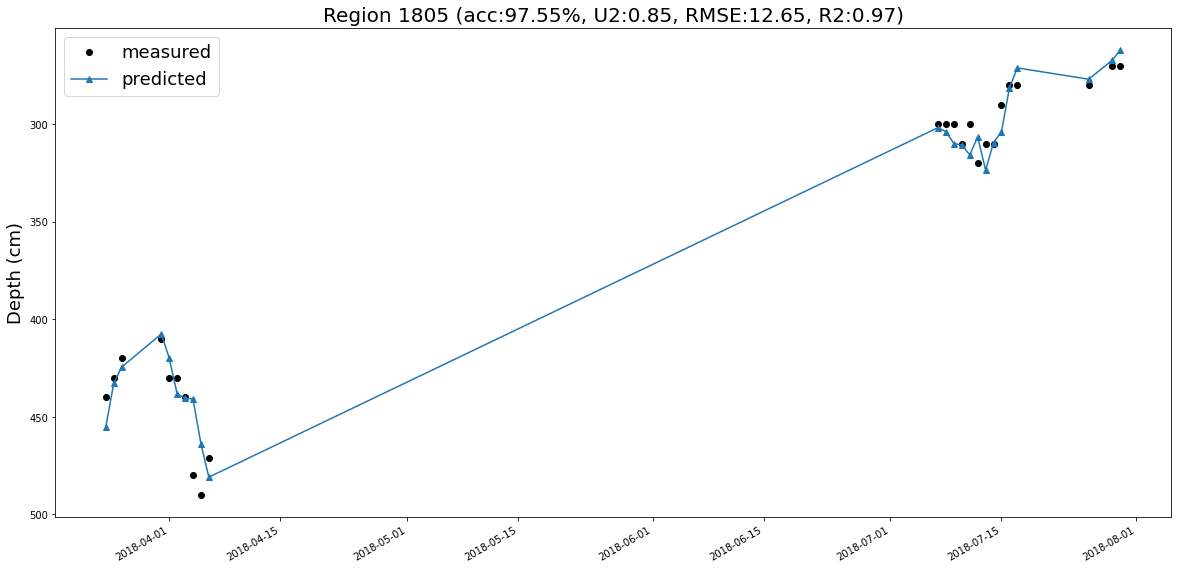

In [42]:
region = 1805

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

In [43]:
metricDF = pd.DataFrame(columns=['no_values', 'accuracy', 'U2', 'RMSE', 'R2'])

for reg, grp in predicted_values.groupby('region_id'):
    out_dict = {}
    out_dict['no_values'] = len(grp)
    out_dict['accuracy'] = 100*get_accuracy(grp['measured'], grp['predicted'])
    out_dict['U2'] = get_u2(grp['measured'], grp['predicted'], grp['previous'])
    out_dict['RMSE'] = get_rmse(grp['measured'], grp['predicted'])
    out_dict['R2'] = r2_score(grp['measured'], grp['predicted'])
    
    metricDF.loc[reg] = out_dict


/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning

<AxesSubplot:>

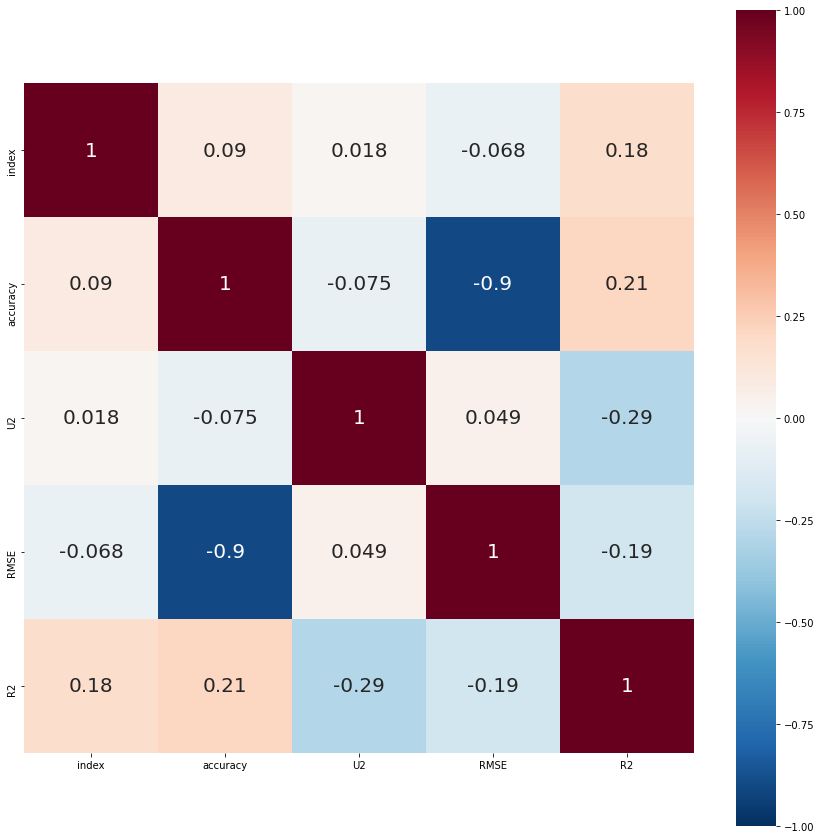

In [44]:
fig,ax = plt.subplots(figsize=(15,15))

sns.heatmap(metricDF.sort_values(by='no_values', ascending=False).reset_index().corr(), 
            vmin=-1, vmax=1., cmap='RdBu_r', ax=ax, square=True, annot=True, 
            annot_kws={"size": 20})

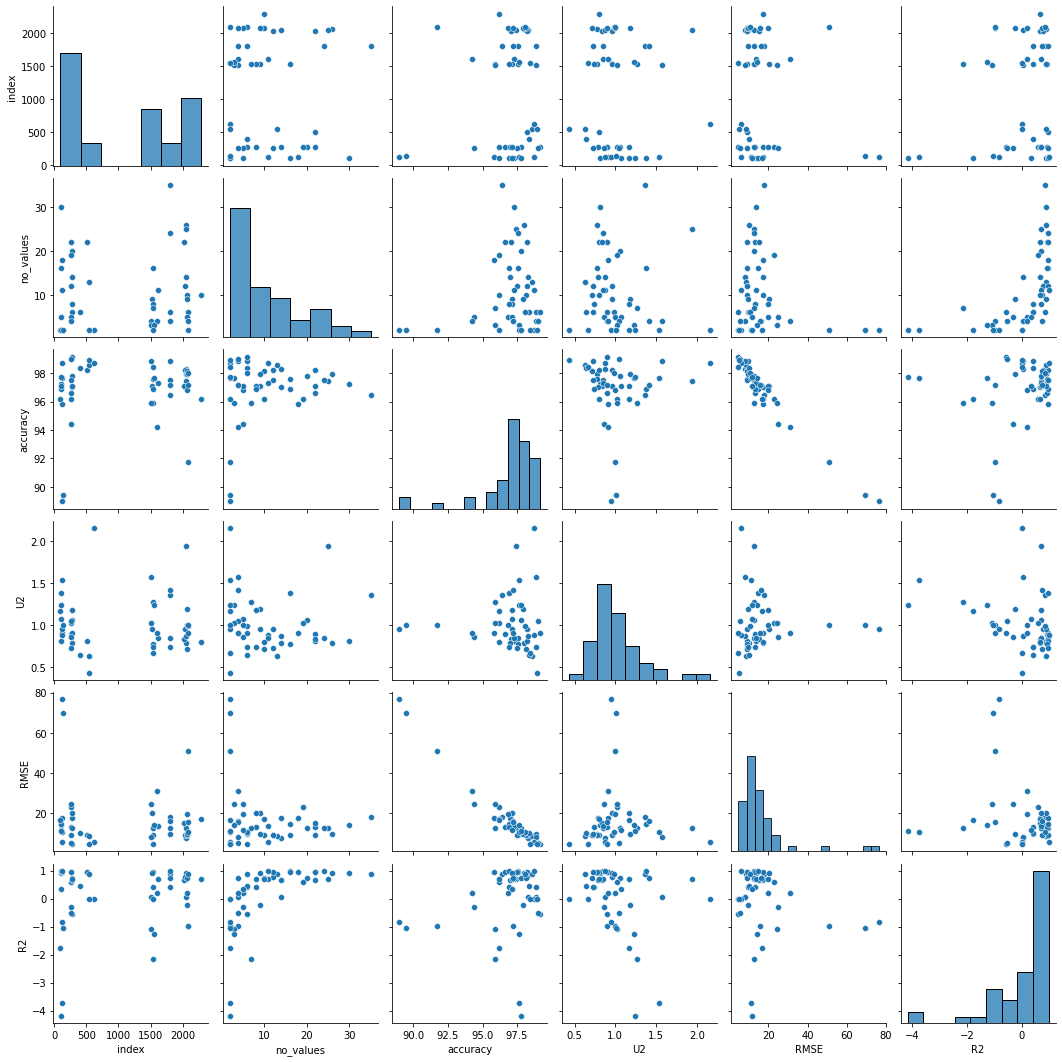

In [45]:
sns.pairplot(metricDF.sort_values(by='no_values', ascending=False).reset_index().dropna())

In [46]:
metricDF.sort_values(by='no_values', ascending=False).head()

no_values   accuracy        U2       RMSE        R2
1802.0        35  96.444586  1.360051  17.948144  0.878226
102.0         30  97.246861  0.811777  13.905826  0.905766
2051.0        26  97.975603  0.780611   9.862812  0.898958
2048.0        25  97.454320  1.941883  12.716780  0.713482
1805.0        24  97.550875  0.848104  12.653863  0.972706

In [47]:
metricDF.loc[list(set(test_X['region_id'].unique()) - set(train_X['region_id'].unique()))].sort_values(by='no_values', ascending=False)

no_values   accuracy        U2       RMSE        R2
2027.0        22  97.077592  0.833333  15.318115  0.664383
2030.0        12  98.235965  0.954844   9.270716  0.783656
1610.0        11  97.295525  0.850505  13.726978  0.707613
2081.0         6  98.049148  0.984654  10.612352  0.873695
393.0          6  98.392365  0.636552  10.185310  0.435819
2072.0         5  96.838874  0.994301  19.842882  0.188450
1607.0         4  94.203751  0.909132  31.030579  0.191353
1556.0         3  97.666464  1.233689  14.229131 -1.277767
1511.0         3  95.932216  1.027204  24.530696 -1.082998
1537.0         2  98.454445  0.664848   4.701186  0.000000
2084.0         2  91.723888  0.994328  50.760581 -0.977146
1766.0         1  96.878152       NaN  14.360501       NaN
432.0          1  97.874091       NaN   9.353999       NaN
2032.0         1  93.231952  0.909803  27.748998       NaN
466.0          1  97.621162  0.955981  10.229005       NaN
1522.0         1  99.275889       NaN   3.258500       NaN
756.0          1  99.036679  0.251872   4.307009       NaN
652.0          1  98.980256       NaN   3.977000       NaN

Print the average metrics for the **overall test set** and **only the regions not present in the training set**.

In [49]:
print(metricDF.mean())
print(metricDF.loc[list(set(test_X['region_id'].unique()) - set(train_X['region_id'].unique()))].sort_values(by='no_values', ascending=False).mean())

no_values     8.149254
accuracy     96.921599
U2            0.993262
RMSE         15.100600
R2            0.062545
dtype: float64
no_values     4.611111
accuracy     97.042690
U2            0.871503
RMSE         15.413530
R2            0.046096
dtype: float64


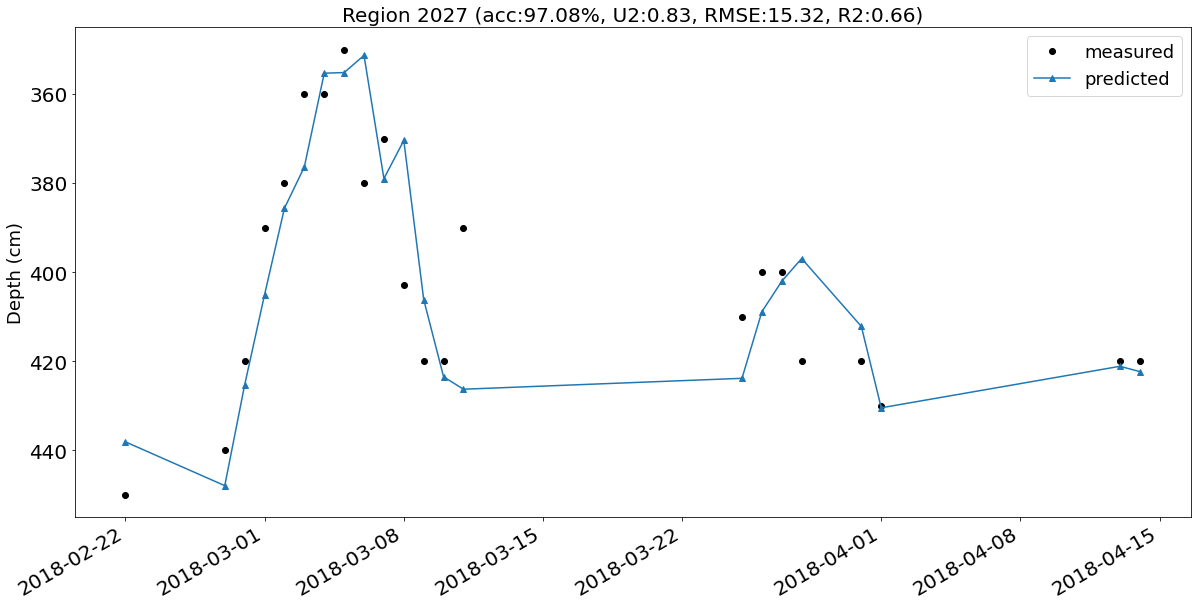

In [50]:
region = 2027

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


Not too great but also gives promise that with more data this would improve a lot (Quincy!).

# Modelling as before but including the water levels as well

Now let's try adding features:
* water levels (with subtracted median for each)
* add measurements from 2 days ago (fewer data points)

In [51]:
levelDF = pd.read_csv('../data/processed/hi_divW_20110101080000-20180930080000_h8min_100mx3.csv', sep=';')

levelDF['date'] = pd.to_datetime(levelDF['date'], format='%Y-%m-%d')
levelDF.set_index('date', inplace=True)
levelDF.columns = [int(i[2:]) for i in levelDF.columns]
# levelDF.reset_index(inplace=True)

# levelDF = pd.melt(levelDF, id_vars=['date'])
# levelDF.rename(columns={'variable':'region_id', 'value': 'level_cmNAP'}, inplace=True)
# levelDF['region_id'] = levelDF['region_id'].astype(int)

print(levelDF.shape)
# print(levelDF.dtypes)
levelDF.head()

(2830, 2529)


0     1     2     3     4     5     6     7     8     9     ...  \
date                                                                    ...   
2011-01-01  1022  1021  1021  1020  1020  1020  1019  1019  1019  1018  ...   
2011-01-02  1002  1001  1001  1000  1000  1000   999   999   999   998  ...   
2011-01-03   992   991   991   990   990   990   989   989   989   988  ...   
2011-01-04   979   978   978   977   977   977   976   976   976   975  ...   
2011-01-05   963   962   962   961   961   961   960   960   960   959  ...   

            2519  2520  2521  2522  2523  2524  2525  2526  2527  2528  
date                                                                    
2011-01-01   102   102   102   102   102   102   102   102   102   102  
2011-01-02   106   106   106   106   106   106   106   106   106   106  
2011-01-03    94    94    94    94    94    94    94    94    94    94  
2011-01-04    89    89    89    89    89    89    89    89    89    89  
2011-01-05    76    76    76    76    76    76    76    76    76    76  

[5 rows x 2529 columns]

In [52]:
cnt = pivDF.diff().count() # how many measurements on the consecutive days there are 

dataDF = pd.DataFrame(columns=['today', 'diff_tomorrow', 'region_id'])

for i, region in enumerate(cnt[cnt > 0].index):
    sys.stdout.write('\rDoing region {} ({}/{})'.format(region,i+1, (cnt > 0).sum()))
    
    tmpDF = pivDF.diff()[region].dropna().copy()
    tmpDF.index = tmpDF.index.map(lambda x: x - pd.Timedelta(days=1))
    tmpDF = pd.DataFrame(tmpDF)
    tmpDF.columns = ['diff_tomorrow']
    tmpDF['today'] = pivDF.loc[tmpDF.index,region]
    tmpDF['region_id'] = region
    
    dataDF = pd.concat([dataDF, tmpDF], axis=0)

Doing region 2385.0 (290/290)

In [53]:
dataDF.head()

today  diff_tomorrow  region_id
2015-01-07  652.999983      41.800005        0.0
2015-01-07  722.299990      42.000014        1.0
2015-01-07  751.499995      51.300008        2.0
2015-01-07  682.200010      61.299998        3.0
2015-01-07  711.800010      44.699986        4.0

In [54]:
disDF = pd.DataFrame(columns=['discharge_{}h'.format(i) for i in range(-24,49)])

for i,(ind,row) in enumerate(dataDF.iterrows()):
    sys.stdout.write('\rDoing row {}/{}'.format(i+1,len(dataDF)))
    
    disDF.loc[len(disDF)] = dischargeDF.loc[ind - pd.Timedelta(hours=16):ind + pd.Timedelta(days=2, hours=8), 'PANNDSKP'].values

Doing row 2830/2830

In [55]:
levDF = pd.DataFrame(columns=['level_{}d'.format(i) for i in range(-2,2)])

for i,(ind,row) in enumerate(dataDF.iterrows()):
    sys.stdout.write('\rDoing row {}/{}'.format(i+1,len(dataDF)))
    
    levDF.loc[len(levDF)] = levelDF.loc[ind - pd.Timedelta(days=2):ind + pd.Timedelta(days=1), row['region_id']].values

Doing row 2830/2830

In [56]:
levDF.head()

level_-2d level_-1d level_0d level_1d
0       897       954     1060     1117
1       896       953     1059     1116
2       896       953     1059     1116
3       895       952     1058     1115
4       895       952     1057     1115

In [57]:
dataDF.reset_index(inplace=True)
dataDF.rename(columns={'index':'date'}, inplace=True)

In [58]:
dataDF = pd.merge(dataDF, disDF, left_index=True, right_index=True)
dataDF = pd.merge(dataDF, levDF, left_index=True, right_index=True)

dataDF.sort_values(by='date', inplace=True)
dataDF.head()

date  today  diff_tomorrow  region_id  discharge_-24h  \
1923 2011-01-03  420.0           70.0     1799.0         1925.48   
1924 2011-02-03  480.0          -30.0     1799.0         1711.80   
394  2011-02-05  440.0          -10.0      254.0         1593.25   
395  2011-02-06  430.0          -30.0      254.0         1574.92   
1423 2011-02-08  410.0            0.0      533.0         1512.13   

      discharge_-23h  discharge_-22h  discharge_-21h  discharge_-20h  \
1923         1925.48         1905.60         1920.95         1940.75   
1924         1707.46         1703.13         1698.80         1717.69   
394          1593.25         1600.28         1589.01         1596.06   
395          1574.92         1586.11         1581.88         1581.91   
1423         1507.98         1519.03         1507.98         1508.00   

      discharge_-19h  ...  discharge_43h  discharge_44h  discharge_45h  \
1923         1928.61  ...        1742.99        1750.39        1734.27   
1924         1713.34  ...        1579.14        1579.14        1579.14   
394          1618.52  ...        1527.36        1523.20        1512.13   
395          1581.91  ...        1506.58        1495.55        1481.69   
1423         1503.85  ...        1483.03        1490.01        1519.10   

      discharge_46h  discharge_47h  discharge_48h  level_-2d  level_-1d  \
1923        1741.66        1744.64        1744.64        399        378   
1924        1579.14        1574.92        1574.92        355        338   
394         1512.13        1505.21        1512.13        852        839   
395         1506.58        1506.58        1524.42        839        832   
1423        1514.93        1510.78        1521.80        729        721   

      level_0d  level_1d  
1923       368       354  
1924       321       312  
394        832       825  
395        825       816  
1423       717       720  

[5 rows x 81 columns]

In [59]:
train_X = dataDF[dataDF['date'] < '2018'].drop(['date','diff_tomorrow'], axis=1)
train_y = dataDF.loc[dataDF['date'] < '2018', 'diff_tomorrow']

test_X = dataDF[dataDF['date'] >= '2018'].drop(['date','diff_tomorrow'], axis=1)
text_y = dataDF.loc[dataDF['date'] >= '2018', 'diff_tomorrow']

In [60]:
et = ExtraTreesRegressor(n_estimators=100)

et.fit(train_X, train_y)

ExtraTreesRegressor()

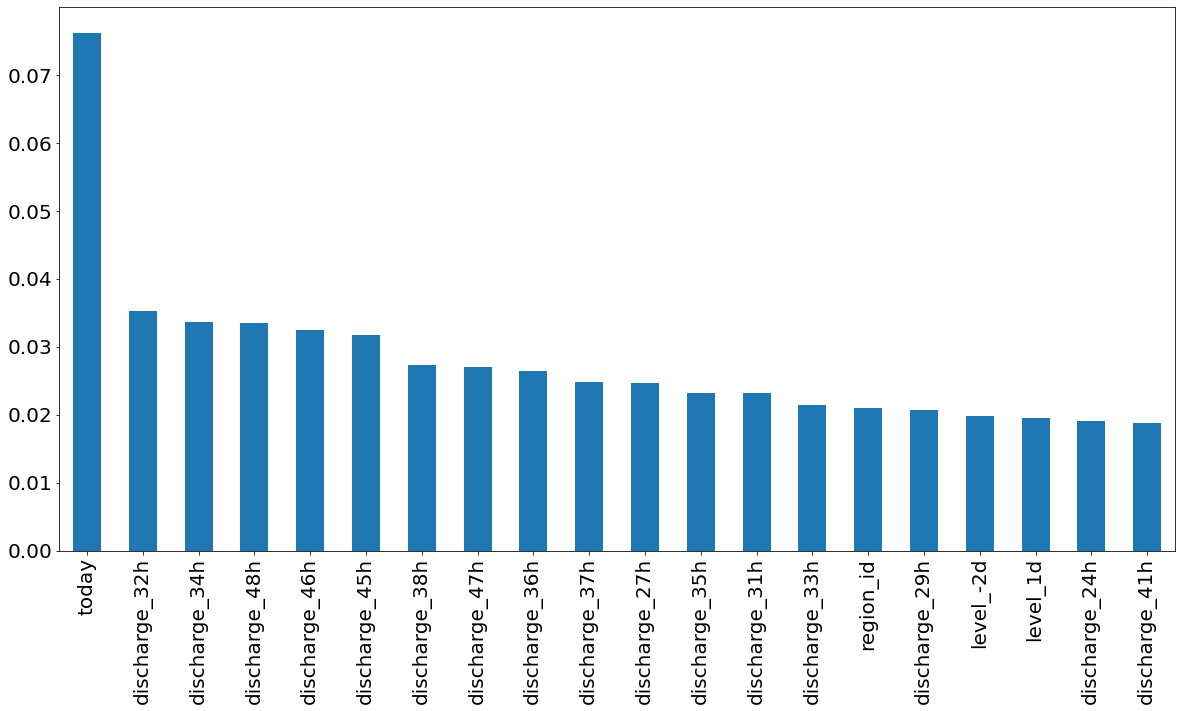

In [61]:
feat_imp = pd.Series(et.feature_importances_)
feat_imp.index = train_X.columns
feat_imp.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(20,10))

feat_imp.iloc[:20].plot.bar(ax=ax, color='#1f77b4')

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


In [62]:
predDF = dataDF.loc[dataDF['date'] >= '2018', ['date', 'region_id', 'today', 'diff_tomorrow']]
predDF['pred_diff_tomorrow'] = et.predict(test_X)

predDF.head()

date  region_id  today  diff_tomorrow  pred_diff_tomorrow
592  2018-02-12      268.0  470.0          -10.0           -3.887000
1667 2018-02-13     1511.0  480.0            0.0           -8.174000
593  2018-02-13      268.0  460.0          -20.0           -0.293000
1916 2018-02-14     1766.0  460.0            0.0           13.800501
1668 2018-02-14     1511.0  480.0          -40.0            1.140000

In [63]:
predicted_values = predDF.copy()
predicted_values.set_index('date', inplace=True)
predicted_values['measured'] = predicted_values['today'] + predicted_values['diff_tomorrow']
predicted_values['predicted'] = predicted_values['today'] + predicted_values['pred_diff_tomorrow']
predicted_values.drop(['diff_tomorrow', 'pred_diff_tomorrow'], axis=1, inplace=True)
predicted_values.index = predicted_values.index.map(lambda x: x + pd.Timedelta(days=1))
predicted_values.rename(columns={'today':'previous'}, inplace=True)

predicted_values.sample(5)

region_id  previous  measured  predicted
date                                                
2018-05-16     1802.0     350.0     360.0   366.6835
2018-06-18     2051.0     420.0     420.0   413.9365
2018-04-25      503.0     430.0     430.0   431.1630
2018-05-14     1607.0     330.0     330.0   343.0080
2018-06-04     1802.0     380.0     420.0   399.5860

Text(0.5, 1.0, 'Region 2051 (acc:97.90%, U2:0.78, RMSE:9.84, R2:0.90)')

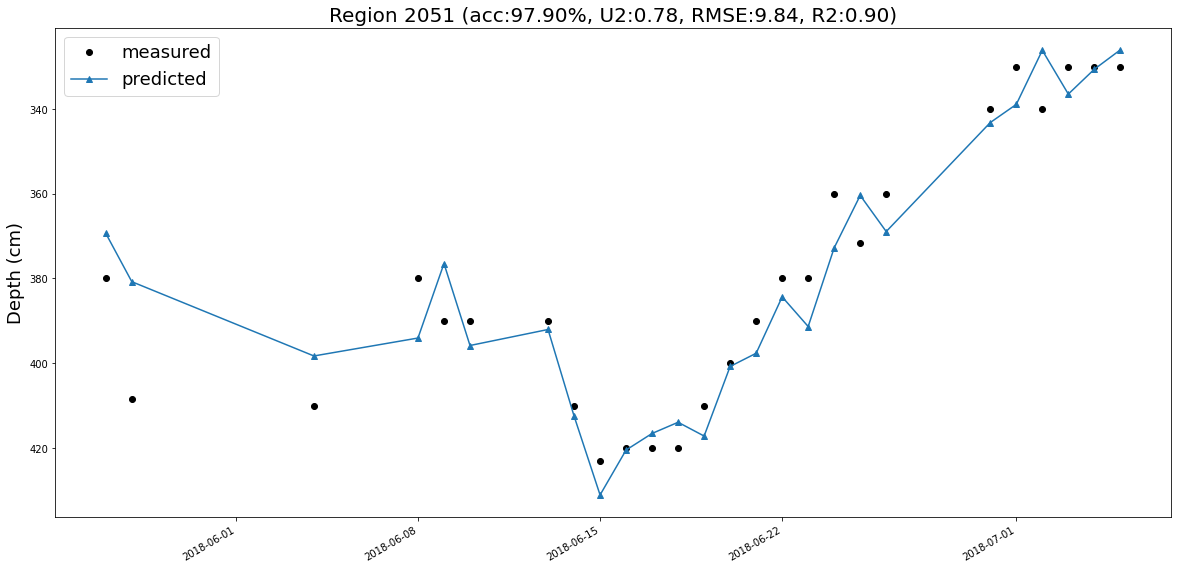

In [64]:
region = 2051

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

In [65]:
metricDF = pd.DataFrame(columns=['no_values', 'accuracy', 'U2', 'RMSE', 'R2'])

for reg,grp in predicted_values.groupby('region_id'):
    out_dict = {}
    out_dict['no_values'] = len(grp)
    out_dict['accuracy'] = 100*get_accuracy(grp['measured'], grp['predicted'])
    out_dict['U2'] = get_u2(grp['measured'], grp['predicted'], grp['previous'])
    out_dict['RMSE'] = get_rmse(grp['measured'], grp['predicted'])
    out_dict['R2'] = r2_score(grp['measured'], grp['predicted'])
    
    metricDF.loc[reg] = out_dict


/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning

<AxesSubplot:>

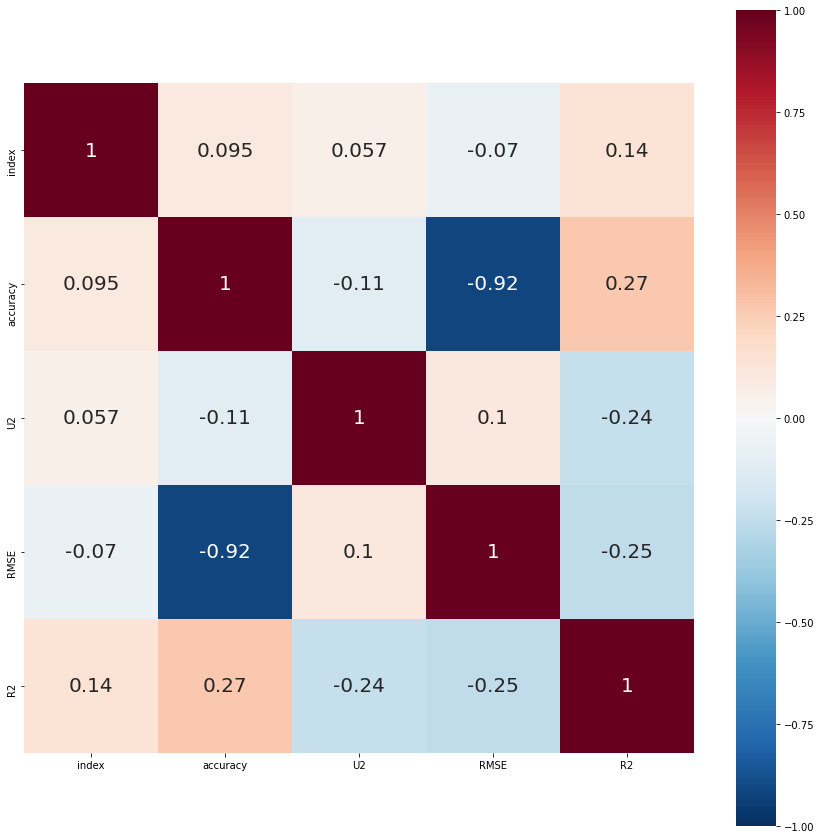

In [66]:
fig,ax = plt.subplots(figsize=(15,15))

sns.heatmap(metricDF.sort_values(by='no_values', ascending=False).reset_index().corr(), 
            vmin=-1, vmax=1., cmap='RdBu_r', ax=ax, square=True, annot=True, 
            annot_kws={"size": 20})

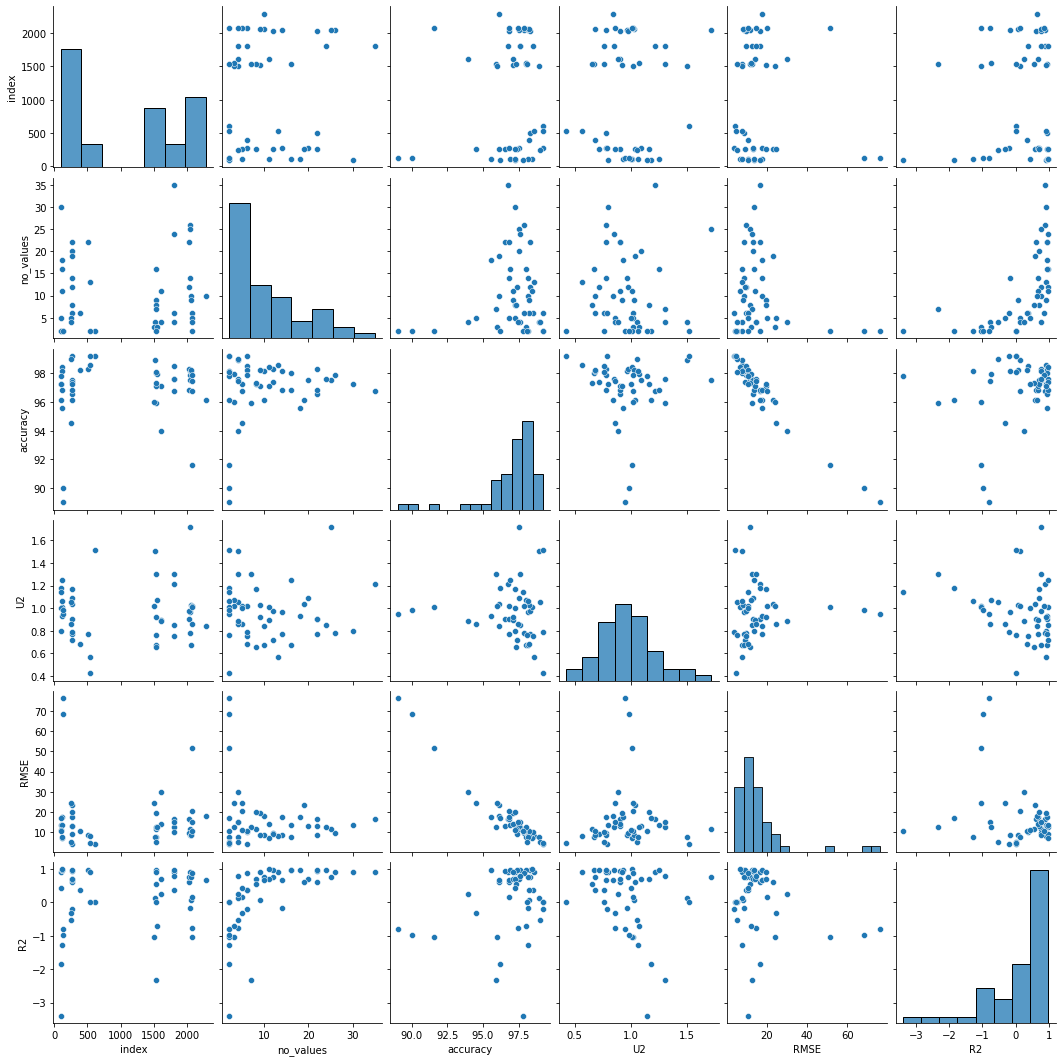

In [67]:
sns.pairplot(metricDF.sort_values(by='no_values', ascending=False).reset_index().dropna())

In [68]:
metricDF.sort_values(by='no_values', ascending=False).head()

no_values   accuracy        U2       RMSE        R2
1802.0        35  96.736746  1.211760  16.649810  0.895206
102.0         30  97.266091  0.798416  13.617982  0.909627
2051.0        26  97.899592  0.781803   9.841479  0.899394
2048.0        25  97.511521  1.718173  11.610033  0.761183
1805.0        24  97.586972  0.853519  12.627429  0.972820

In [69]:
metricDF.loc[list(set(test_X['region_id'].unique()) - set(train_X['region_id'].unique()))].sort_values(by='no_values', ascending=False)

no_values   accuracy        U2       RMSE        R2
2027.0        22  96.859260  0.904293  16.569440  0.607311
2030.0        12  98.312239  0.973083   9.553127  0.770274
1610.0        11  97.086170  0.899003  14.116652  0.690778
2081.0         6  97.911399  1.015378  10.857774  0.867786
393.0          6  98.216133  0.682849  10.848932  0.359906
2072.0         5  96.794421  1.020592  20.364356  0.145235
1607.0         4  93.965131  0.882870  29.879592  0.250229
1556.0         3  97.988464  1.072583  12.377505 -0.723530
1511.0         3  96.006213  1.020354  24.336321 -1.050119
1537.0         2  98.062593  0.763679   5.400028  0.000000
2084.0         2  91.606192  1.009416  51.531108 -1.037626
1766.0         1  96.999891       NaN  13.800501       NaN
432.0          1  97.815682       NaN   9.611000       NaN
2032.0         1  93.670854  0.850803  25.949498       NaN
466.0          1  97.095232  1.167336  12.490504       NaN
1522.0         1  99.189556       NaN   3.647000       NaN
756.0          1  99.422834  0.150907   2.580509       NaN
652.0          1  99.386923       NaN   2.391000       NaN

In [70]:
print(metricDF.mean())
print(metricDF.loc[list(set(test_X['region_id'].unique()) - set(train_X['region_id'].unique()))].sort_values(by='no_values', ascending=False).mean())

no_values     8.149254
accuracy     97.041562
U2            0.948450
RMSE         14.542775
R2            0.151226
dtype: float64
no_values     4.611111
accuracy     97.021621
U2            0.886653
RMSE         15.350269
R2            0.080022
dtype: float64


Text(0.5, 1.0, 'Region 2027 (acc:96.86%, U2:0.90, RMSE:16.57, R2:0.61)')

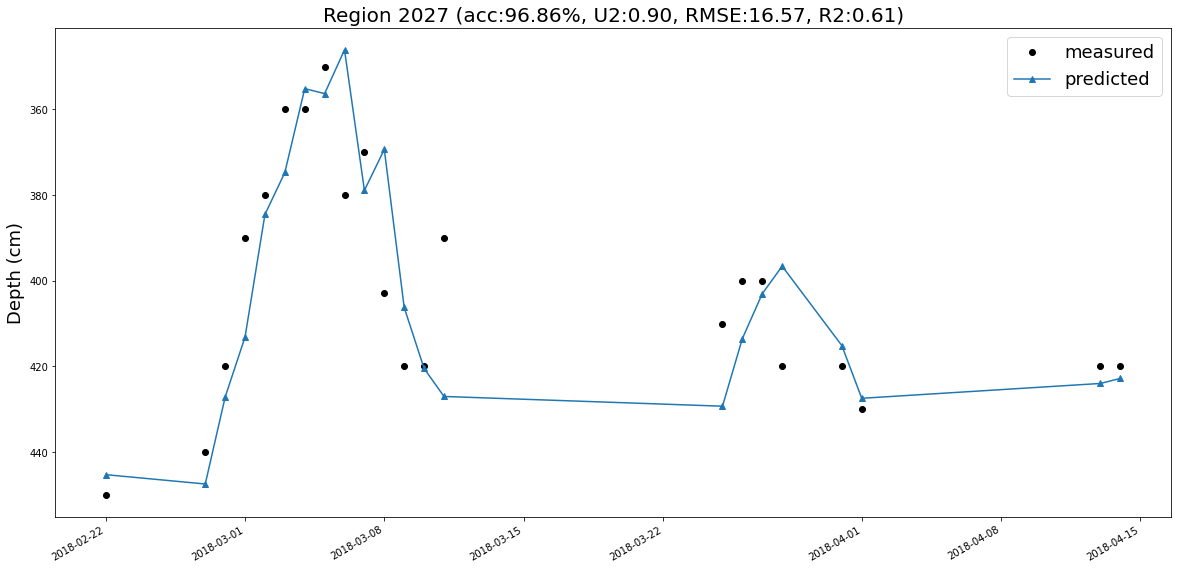

In [71]:
region = 2027 # 393

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

# Using two previous days (instead of just one) for modelling

We appropriately extend the discharge and the water level series.

In [72]:
cnt = pivDF.diff().diff().count() # how many measurements on the consecutive days there are 

dataDF = pd.DataFrame(columns=['today', 'diff_tomorrow', 'yesterday', 'region_id'])

for i, region in enumerate(cnt[cnt > 0].index):
    sys.stdout.write('\rDoing region {} ({}/{})'.format(region,i+1, (cnt > 0).sum()))
    
    tmpDF = pivDF.diff()[~pivDF.diff().diff().isnull()][region].dropna().copy()
    tmpDF.index = tmpDF.index.map(lambda x: x - pd.Timedelta(days=1))
    tmpDF = pd.DataFrame(tmpDF)
    tmpDF.columns = ['diff_tomorrow']
    tmpDF['today'] = pivDF.loc[tmpDF.index,region].values
    tmpDF['yesterday'] = pivDF.loc[tmpDF.index.map(lambda x: x - pd.Timedelta(days=1)), region].values
    tmpDF['region_id'] = region
    
    dataDF = pd.concat([dataDF, tmpDF], axis=0)

Doing region 2385.0 (95/95)

In [73]:
print(dataDF.shape)
dataDF.head()

(1748, 4)


today  diff_tomorrow  yesterday  region_id
2017-03-20  450.0     152.899990      460.0       76.0
2016-03-22  390.0     -10.000000      400.0       93.0
2016-03-23  380.0      25.600004      390.0       93.0
2016-08-28  310.0     -10.000000      320.0       97.0
2016-08-29  300.0       0.000000      310.0       97.0

In [74]:
disDF = pd.DataFrame(columns=['discharge_{}h'.format(i) for i in range(-24,49)])

for i,(ind,row) in enumerate(dataDF.iterrows()):
    sys.stdout.write('\rDoing row {}/{}'.format(i+1,len(dataDF)))
    
    disDF.loc[len(disDF)] = dischargeDF.loc[ind - pd.Timedelta(hours=16):ind + pd.Timedelta(days=2, hours=8), 'PANNDSKP'].values

Doing row 1748/1748

In [75]:
levDF = pd.DataFrame(columns=['level_{}d'.format(i) for i in range(-2,2)])

for i,(ind,row) in enumerate(dataDF.iterrows()):
    sys.stdout.write('\rDoing row {}/{}'.format(i+1,len(dataDF)))
    
    levDF.loc[len(levDF)] = levelDF.loc[ind - pd.Timedelta(days=2):ind + pd.Timedelta(days=1), row['region_id']].values

Doing row 1748/1748

In [76]:
dataDF.reset_index(inplace=True)
dataDF.rename(columns={'index':'date'}, inplace=True)

In [77]:
dataDF = pd.merge(disDF,dataDF, left_index=True, right_index=True)
dataDF = pd.merge(dataDF, levDF, left_index=True, right_index=True)

dataDF.sort_values(by='date', inplace=True)

In [78]:
dataDF['date'].map(lambda x : x.year).unique()

for y in dataDF['date'].map(lambda x : x.year).unique():
    print('Fraction before {}: {}%'.format(y, 100*len(dataDF[dataDF['date'] < '{}'.format(y)])/len(dataDF)))

Fraction before 2011: 0.0%
Fraction before 2012: 6.636155606407323%
Fraction before 2013: 11.784897025171624%
Fraction before 2014: 17.391304347826086%
Fraction before 2015: 24.48512585812357%
Fraction before 2016: 32.494279176201374%
Fraction before 2017: 39.016018306636155%
Fraction before 2018: 78.77574370709382%


In [79]:
train_X = dataDF[dataDF['date'] < '2018'].drop(['date','diff_tomorrow'], axis=1)
train_y = dataDF.loc[dataDF['date'] < '2018', 'diff_tomorrow']

test_X = dataDF[dataDF['date'] >= '2018'].drop(['date','diff_tomorrow'], axis=1)
text_y = dataDF.loc[dataDF['date'] >= '2018', 'diff_tomorrow']

In [80]:
et = ExtraTreesRegressor(n_estimators=100)

et.fit(train_X, train_y)

ExtraTreesRegressor()

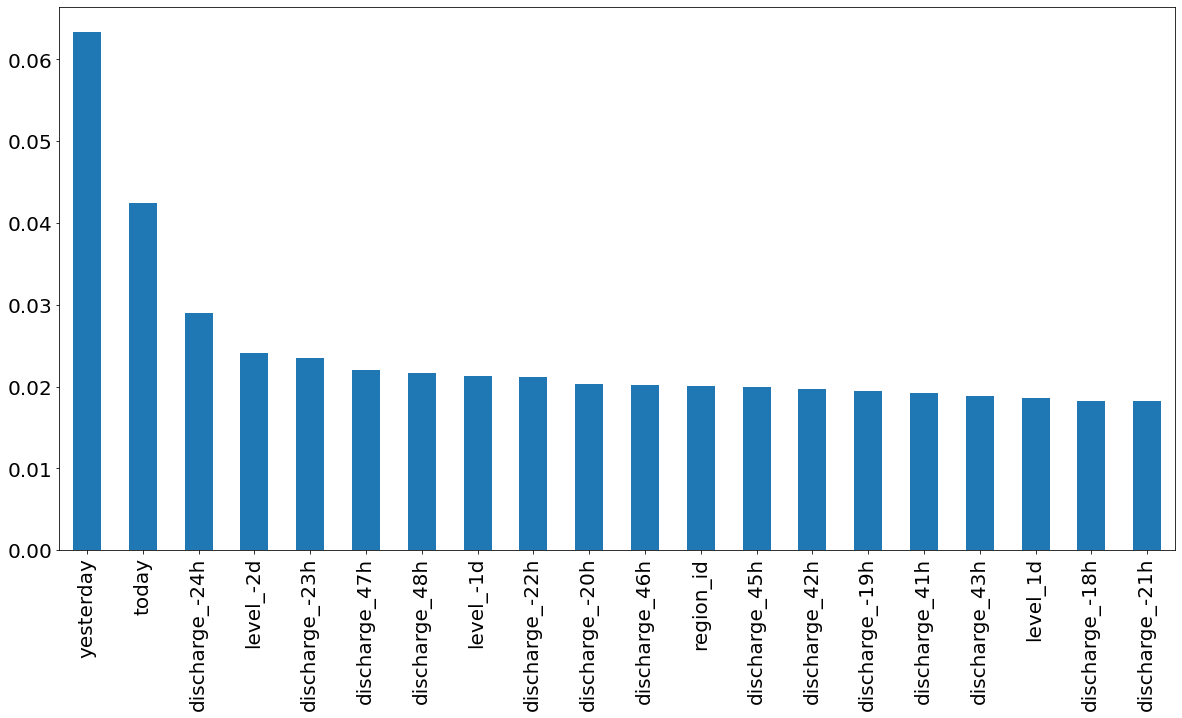

In [81]:
feat_imp = pd.Series(et.feature_importances_)
feat_imp.index = train_X.columns
feat_imp.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(20,10))

feat_imp.iloc[:20].plot.bar(ax=ax, color='#1f77b4')

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


In [82]:
predDF = dataDF.loc[dataDF['date'] >= '2018', ['date', 'region_id', 'today', 'diff_tomorrow']]
predDF['pred_diff_tomorrow'] = et.predict(test_X)

predDF.head()

date  region_id  today  diff_tomorrow  pred_diff_tomorrow
253  2018-02-13      268.0  460.0          -20.0           17.016499
1004 2018-02-14     1511.0  480.0          -40.0           -1.179500
254  2018-02-14      268.0  440.0          -10.0           32.823498
255  2018-02-15      268.0  430.0          -20.0           21.130999
1005 2018-02-15     1511.0  440.0           10.0            1.849999

In [83]:
predicted_values = predDF.copy()
predicted_values.set_index('date', inplace=True)
predicted_values['measured'] = predicted_values['today'] + predicted_values['diff_tomorrow']
predicted_values['predicted'] = predicted_values['today'] + predicted_values['pred_diff_tomorrow']
predicted_values.drop(['diff_tomorrow', 'pred_diff_tomorrow'], axis=1, inplace=True)
predicted_values.index = predicted_values.index.map(lambda x: x + pd.Timedelta(days=1))
predicted_values.rename(columns={'today':'previous'}, inplace=True)

predicted_values.sample(5)

region_id  previous  measured   predicted
date                                                 
2018-04-05      612.0     450.0     450.0  456.946500
2018-03-17     1802.0     450.0     460.0  475.719499
2018-04-13     2081.0     420.0     420.0  427.052500
2018-05-11     1802.0     390.0     360.0  389.948000
2018-07-25      114.0     220.0     220.0  225.482000

In [84]:
predicted_values['region_id'].value_counts().iloc[:5]

1802.0    28
102.0     22
2051.0    21
2048.0    20
1805.0    19
Name: region_id, dtype: int64

Text(0.5, 1.0, 'Region 2051 (acc:97.90%, U2:0.85, RMSE:10.04, R2:0.91)')

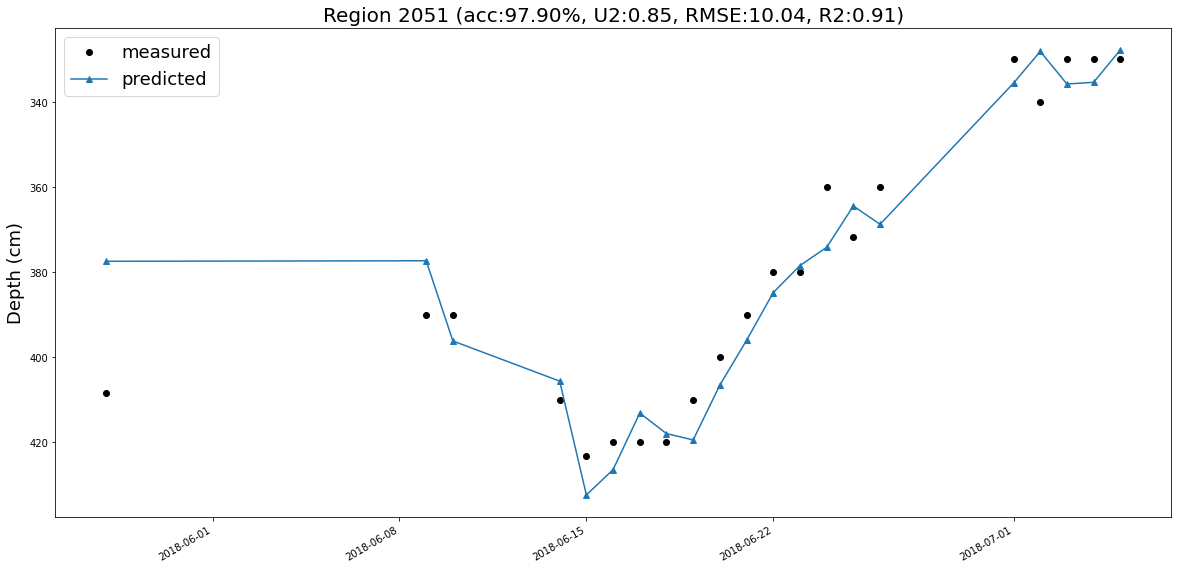

In [85]:
region = 2051

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

Text(0.5, 1.0, 'Region 102 (acc:97.18%, U2:0.81, RMSE:13.39, R2:0.92)')

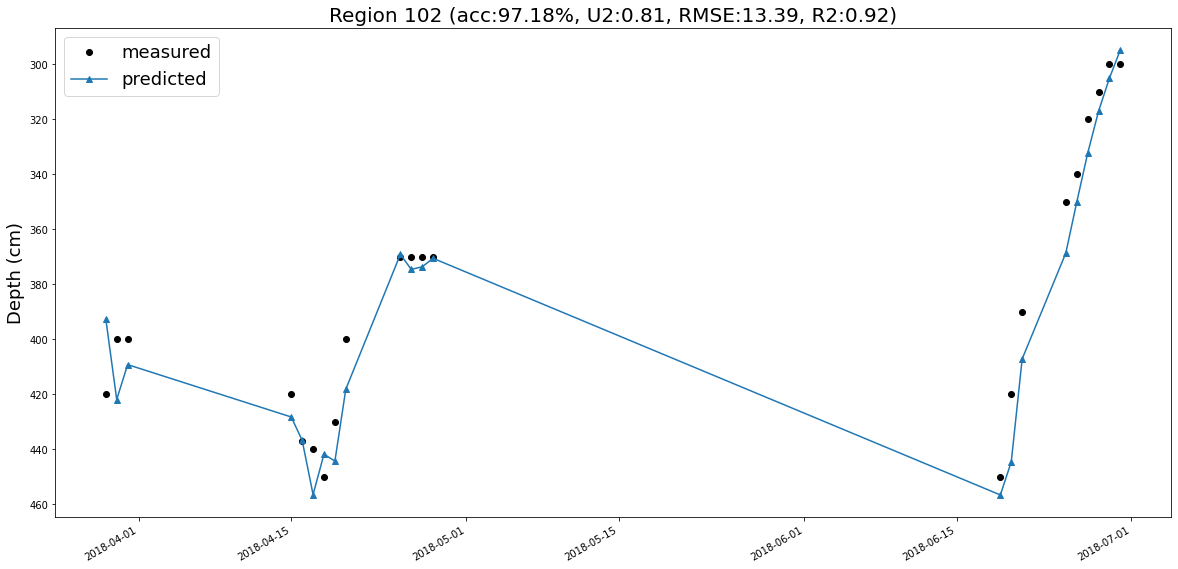

In [86]:
region = 102

fig,ax = plt.subplots(figsize=(20,10))
predicted_values.loc[predicted_values['region_id'] == region, 'measured'].plot(ax=ax, linestyle='none', marker='o', color='black', label='measured')
predicted_values.loc[predicted_values['region_id'] == region, 'predicted'].plot(ax=ax, marker='^', label='predicted')

ax.legend(fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Depth (cm)', fontsize=18)
plt.gca().invert_yaxis()

ax.set_title('Region {0} (acc:{1:.2f}%, U2:{2:.2f}, RMSE:{3:.2f}, R2:{4:.2f})'.format(region, 
                                                                          100*get_accuracy(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                           predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                          get_u2(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'predicted'],
                                                                                 predicted_values.loc[predicted_values['region_id'] == region, 'previous']),
                                                                          get_rmse(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                   predicted_values.loc[predicted_values['region_id'] == region, 'predicted']),
                                                                                     r2_score(predicted_values.loc[predicted_values['region_id'] == region, 'measured'],
                                                                                              predicted_values.loc[predicted_values['region_id'] == region, 'predicted'])), 
             fontsize=20)

In [87]:
metricDF = pd.DataFrame(columns=['no_values', 'accuracy', 'U2', 'RMSE', 'R2'])

for reg,grp in predicted_values.groupby('region_id'):
    out_dict = {}
    out_dict['no_values'] = len(grp)
    out_dict['accuracy'] = 100*get_accuracy(grp['measured'], grp['predicted'])
    out_dict['U2'] = get_u2(grp['measured'], grp['predicted'], grp['previous'])
    out_dict['RMSE'] = get_rmse(grp['measured'], grp['predicted'])
    out_dict['R2'] = r2_score(grp['measured'], grp['predicted'])
    
    metricDF.loc[reg] = out_dict


/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jovyan/conda-envs/river/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning

<AxesSubplot:>

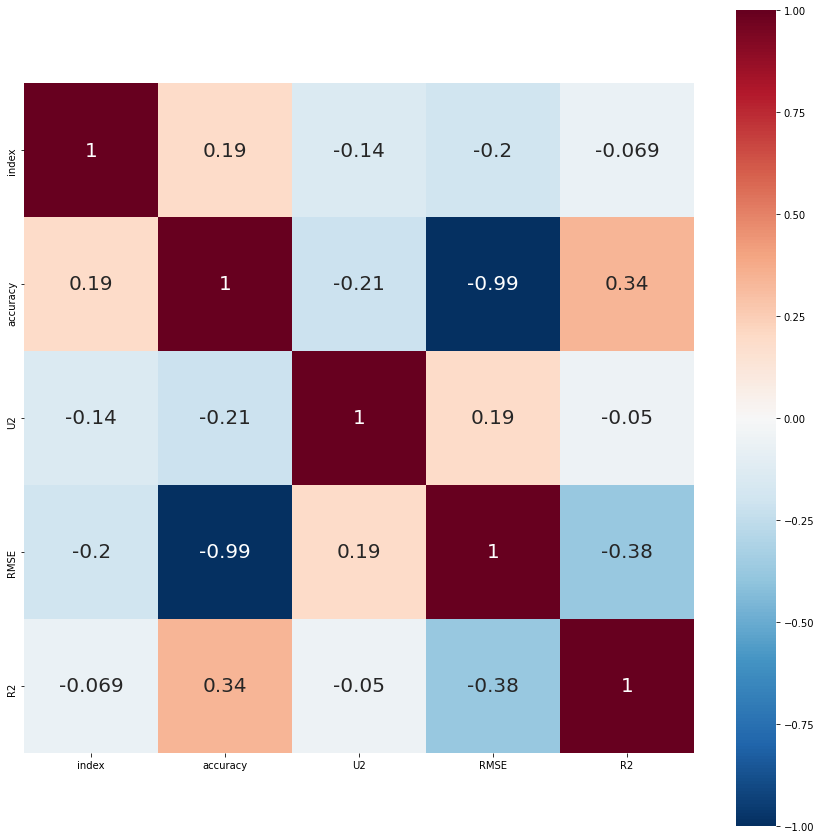

In [88]:
fig,ax = plt.subplots(figsize=(15,15))

sns.heatmap(metricDF.sort_values(by='no_values', ascending=False).reset_index().corr(), 
            vmin=-1, vmax=1., cmap='RdBu_r', ax=ax, square=True, annot=True, 
            annot_kws={"size": 20})

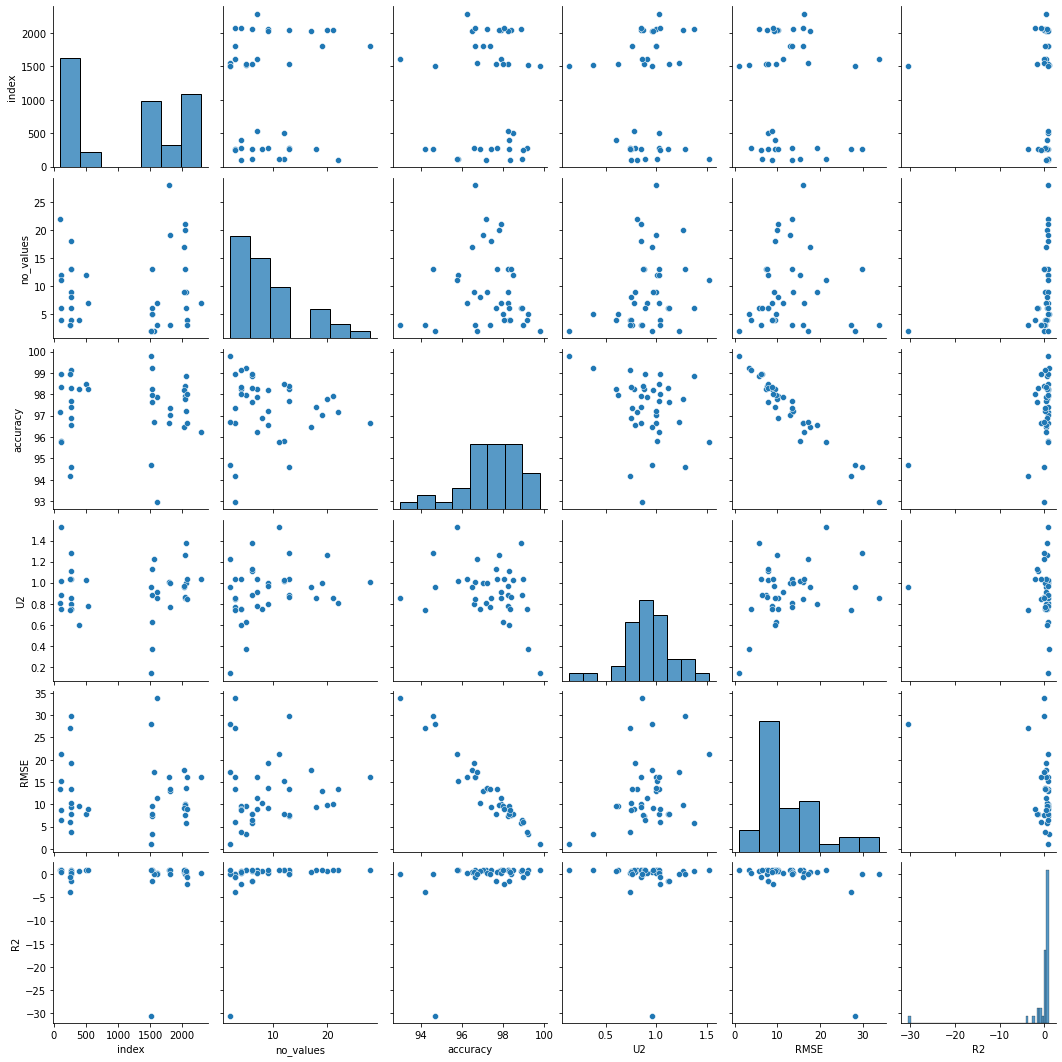

In [89]:
sns.pairplot(metricDF.sort_values(by='no_values', ascending=False).reset_index().dropna())

In [90]:
metricDF.sort_values(by='no_values', ascending=False).head()

no_values   accuracy        U2       RMSE        R2
1802.0        28  96.651340  1.001933  16.043677  0.904872
102.0         22  97.177834  0.808909  13.391423  0.919528
2051.0        21  97.902650  0.852597  10.042593  0.905572
2048.0        20  97.794887  1.265003   9.850857  0.739470
1805.0        19  97.040338  0.999860  13.037037  0.971680

In [91]:
metricDF.loc[list(set(test_X['region_id'].unique()) - set(train_X['region_id'].unique()))].sort_values(by='no_values', ascending=False)

no_values   accuracy        U2        RMSE         R2
2027.0        17  96.485390  0.960123   17.626462   0.475044
2030.0         9  98.214692  0.963957    9.152190   0.794143
1610.0         7  97.886576  0.910589   11.310952   0.341595
105.0          4  98.335478  0.754206    8.713221   0.513891
2081.0         4  98.023020  1.033910    8.878663  -2.153226
274.0          4  99.141348  0.745528    3.797020   0.231074
393.0          4  98.270962  0.602076    9.517507   0.632632
2078.0         3  96.643522  0.845245   16.041766  -0.654317
1607.0         3  92.956867  0.857294   33.773449   0.050165
1511.0         2  94.683024  0.962413   28.048652 -30.469075
1556.0         2  96.718415  1.221473   17.274233   0.000000
1537.0         1  99.680185       NaN    0.863500        NaN
2084.0         1  83.781207  0.993345   71.719505        NaN
118.0          1  96.130270  1.431800   14.318001        NaN
2072.0         1  98.604000  0.587789    5.584000        NaN
126.0          1  79.267296  0.958246  108.473511        NaN
129.0          1  80.641190  0.990247   96.252003        NaN

In [92]:
print(metricDF.mean())
print(metricDF.loc[list(set(test_X['region_id'].unique()) - set(train_X['region_id'].unique()))].sort_values(by='no_values', ascending=False).mean())

no_values     7.571429
accuracy     96.390013
U2            0.935170
RMSE         17.180427
R2           -0.527404
dtype: float64
no_values     3.823529
accuracy     94.439026
U2            0.926140
RMSE         27.137920
R2           -2.748916
dtype: float64
